In [1]:
from lib.abstract_torch import get_device, get_loss, get_optimizer
from lib.dataloader import get_MNIST_loaders, get_FMNIST_loaders
from lib.model import ANN
from lib.train import train
from lib.test import test
from lib.growth_schedules import get_handcrafted_schedule
from lib.visualize import (visualize_pathes,
                          visualize_statistical_reliability,
                          visualize_box_plot)               

import os
import numpy as np

In [2]:
device = get_device()

In [3]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "\\data"

In [4]:
batch_size=128

## Get data loaders

In [5]:
train_loader, val_loader, test_loader = get_FMNIST_loaders(data_path, range(10), batch_size)

## Define, train and test both root & target models

In [6]:
# Network's initial architecture
num_inputs = 28*28
num_hidden = 10
num_outputs = 10

# Network's final architecture
num_hidden_target = 100

# Loss & optimizer
loss_name = "MSE" # "CE"
optimizer_name = "Adam"

# Hyperparameters
num_epochs = 3
lr = 5e-3
growth_schedule = None

# Experiment parameters
num_repetitions = 2

### Root model

In [7]:
test_acc_roots = []
for i in range(num_repetitions) :
    root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
    _ = train(root_model, growth_schedule, loss_name, optimizer_name, lr, train_loader, val_loader, num_epochs, batch_size, device, verbose=0)
    test_acc_root = test(root_model, test_loader, batch_size, device)
    test_acc_roots.append(test_acc_root)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:32<00:00, 10.80s/it]


In [8]:
test_acc_roots

[54.39679487179486, 71.61499999999997]

### Target model

In [9]:
test_acc_targets = []
for i in range(num_repetitions) :
    target_model = ANN(num_inputs, num_hidden_target, num_outputs).to(device)
    _ = train(target_model, growth_schedule, loss_name, optimizer_name, lr, train_loader, val_loader, num_epochs, batch_size, device, verbose=0)
    test_acc_target = test(target_model, test_loader, batch_size, device)
    test_acc_targets.append(test_acc_target)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:30<00:00, 10.08s/it]


In [10]:
test_acc_targets

[82.8019230769231, 83.96448717948718]

## Grow root model

In [11]:
# Growth parameters
init_name = "random"
num_neurons = 9

In [12]:
growth_schedules = get_handcrafted_schedule(num_neurons)[:2]

In [13]:
test_accs_repeted = []
for i in range(num_repetitions) :
    test_accs = []
    for growth_schedule in growth_schedules :
        root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
        _ = train(root_model, 
                  growth_schedule,
                  loss_name, 
                  optimizer_name, lr, 
                  train_loader, val_loader, 
                  num_epochs, batch_size, 
                  device,
                  init_name=init_name,
                  verbose=0)
        test_acc = test(root_model, test_loader, batch_size, device)
        test_accs.append(test_acc)
    test_accs_repeted.append(test_accs)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.71s/it]


In [14]:
test_accs_repeted = np.array(test_accs_repeted)
test_accs = np.mean(test_accs_repeted, 0)

## Visualize results

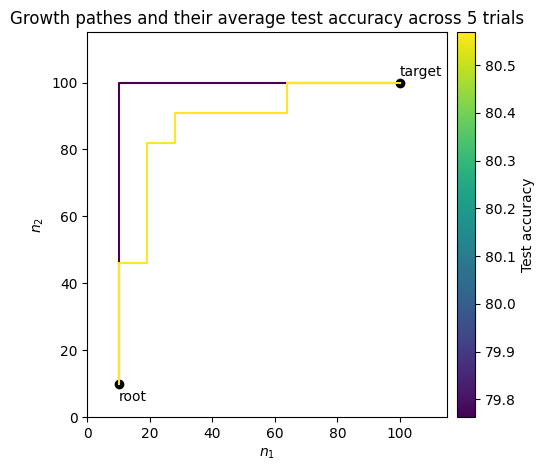

In [15]:
visualize_pathes(num_hidden, num_hidden_target, growth_schedules, test_accs)

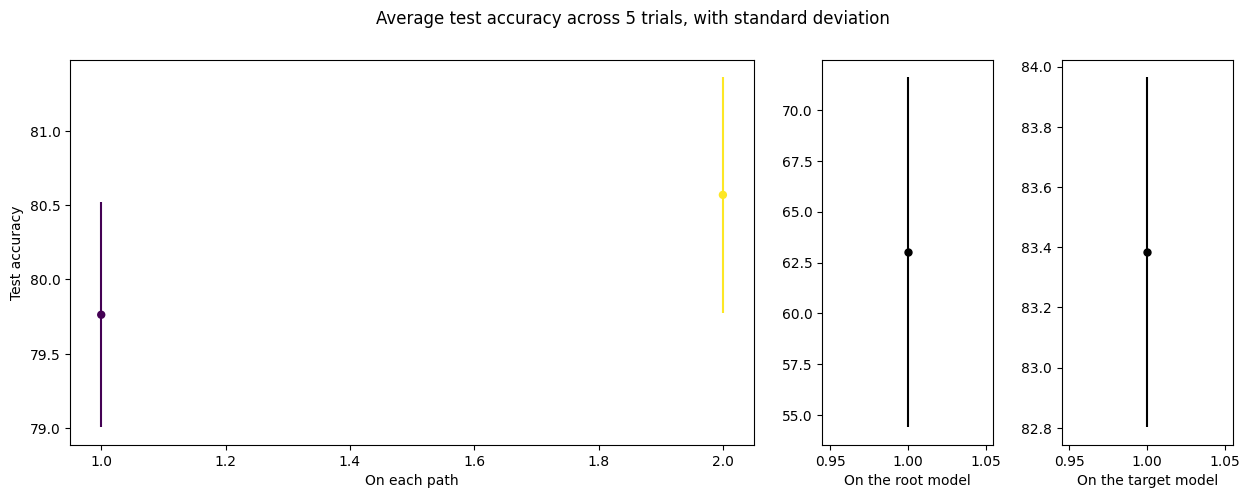

In [16]:
visualize_statistical_reliability (test_accs_repeted, test_accs, test_acc_roots, test_acc_targets,
                                   free_lim=True)

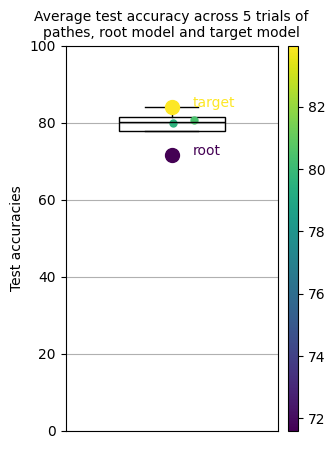

In [17]:
visualize_box_plot(test_accs, test_acc_root, test_acc_target)